# Eksperymenty z FDW

Chcemy zbadać wydajność prostych zapytań na dużych ilościach danych, oryginalnie
pochodzących z pliku CSV. Rozważamy następujące podejścia:

* Czytanie prosto z CSVki za pomocą `file_fdw`
* Wprowadzenie danych do jednej zwykłej tabeli
    * Potencjalnie z indeksem
* Wprowadzenie danych do tabeli zapisanej "kolumnowo" dzięki `cstore_fdw`

## Postać danych i zapytania

Rozważamy tabele postaci

    date       | category | v0  | v1  | v2  | ...
    2011-01-01 | A        | 102 | 134 | 95  | ...
    2011-01-01 | B        | 113 | 97  | 95  | ...
    2011-01-02 | A        | 100 | 89  | 93  | ...
    2011-01-02 | B        | 74  | 103 | 120 | ...
    ...

I zapytania postaci:

* suma po `v{i}` dla pewnego `i` w przedziale dat:
```sql
SELECT SUM(v7) FROM table WHERE date BETWEEN <dzień 1> AND <dzień 2>
```
* jak poprzednio, ale tylko po wierszach z konkretną kategorią:
```sql
... AND category = '<kategoria>'
```

## Eksperymenty

Chcemy zbadać następujące metody:

* `file_fdw`
* zwykła tabela
* zwykła tabela z indeksem na datach
* zwykła tabela z indeksem na kategoriach
* `cstore_fdw`

Dla każdej z nich, chcemy sprawdzić jak zachowuje się przy zmiennej liczbie każdego z następujących parametrów: 

* Liczba kategorii
* Liczba kolumn z wartościami
* Liczba dni w przedziale o który pytamy

W eksperymentach rozważamy następujące wartości parametrów:

* Ketegorie: 1, 10, **20**, 100, 500
* Kolumny: 1, 10, **50**, 100, 500, 1000
* Długośc przediału czasowego: dzień, tydzień, miesiąc, **rok**, 3 lata

**Wyróżniona** wartość każdego parametru to wartość domyślna, którą będziemy trzymali stałą badając inny parametr. 

>Na przykład, kiedy badamy wpływ liczby kolumn na czas wykonania, wygenerujemy dane z **20 kategoriami** i będziemy się pytać o przedziały długości **365 dni**, za każdym razem z inną liczbą kolumn (od 1 o 1000).

## Zbierane dane

Dla każdego eksperymentu chcemy zebrać informacje o

* Czasie wykonania zapytań (średnia z trzech odpaleń)
    * Czasami (ale nie zawsze) pierwsze kilka odpaleń (zwykle jedno lub dwa)
      danej metody jest znacznie wolniejsze od reszty. Żeby uniknąć takich
      statystycznych śmieci, odpalamy pięć razy i bierzemy średnią z
      najszybszych trzech.
* Rozmiarze danych na dysku

Dane dla każdego wywołania zapisujemy w Postgresie, do dalszej analizy przy pomocy Jupytera. Tabele z danymi wyglądają następująco:

```sql
CREATE TABLE experiment_params (
    exp_id INT,           -- identyfikator eksperymentu
    categories INT,       -- liczba kategorii w eksperymencie
    values INT,           -- liczba kolumn z wartościami w eksperymencie
    query_days INT,       -- rozmiar przedziałów czasowych po których sumujemy
    total_days INT,       -- liczba dni dla których zostały wygenerowane dane
    PRIMARY KEY (exp_id)
);

CREATE TABLE experiment_time (
    exp_id INT,           -- identyfikator eksperymentu
    time NUMERIC,         -- czas pojedynczego odpalenia
    method VARCHAR,       -- metoda wykorzystana w tym odpaleniu
    with_category BOOLEAN -- czy w zapytaniu ograniczaliśmy się do jednej kategorii?
);

CREATE TABLE experiment_size (
    exp_id INT,           -- identyfikator eksperymentu
    size INT,             -- rozmiar na dysku
    method VARCHAR        -- rozmiar czego?
);
```

## Analiza czasów wykonania

Zaczynamy od zaimportowania przydatnych bibliotek (do obróbki danych i połączenia z Postgresem) oraz zainicjalizowania połączenia z bazą.

In [2]:
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', size=22)

import psycopg2
conn = psycopg2.connect("dbname=m user=m")
pg = conn.cursor()

import drawings

### Ignorujemy czasy CSV

W analizie czasowej będziemy ignorować metodę `file_fdw` bezpośrednio z CSVki. Wypada ona zawsze o rzędy wielkości gorzej niż pozostałe metody, więc nie dość, że od razu widać, że jest beznadziejna, to jeszcze zupełnie psuje skalę wykresów. Dla przykładu, tak wyglądałby jeden z wykresów gdyby nie ignorować `file_fdw`:

In [44]:
drawings.show_experiment(pg, plt, 'categories', False, ignore=[])

Dane, które rzeczywiście nas interesują są zupełnie nieczytelne.

### O obarzkach

Interesuje nas przede wszystkim względne zachowanie metod &mdash; która najlpeiej się zachowuje przy danej wartości parametru, która najgorzej. Warto jednak też zobaczyć bezwzględne czasy wykonania. Z tego powodu, dla każdego eksperymentu wygenerujemy dwa wykresy:

* Wykres słupkowy z czasami znormalizowanymi do czasu wykonania na zwykłej tabeli bez indeksu. Tu na jednym obrazku będzie łatwo zobaczyć jak metody się zachowują porównywalnie względem siebie, z parametrem przebiegającym rzędy wielkości.
* Normalny wykres liniowy, na którym widać wzrost czasu wykonaia ze zwiększającym się parametrem.

Dla przykładu:

In [45]:
drawings.show_experiment(pg, plt, 'query_days', False)

Dla każdego eksperymentu, najpierw przedstawimy wykresy dla zapytań agregujących cały przedział dat, a następnie dla zapytań, które wybierają tylko wiersze z konkretnej kategorii.

## Zmienna liczba kategorii

In [47]:
drawings.show_experiment(pg, plt, 'categories', False)

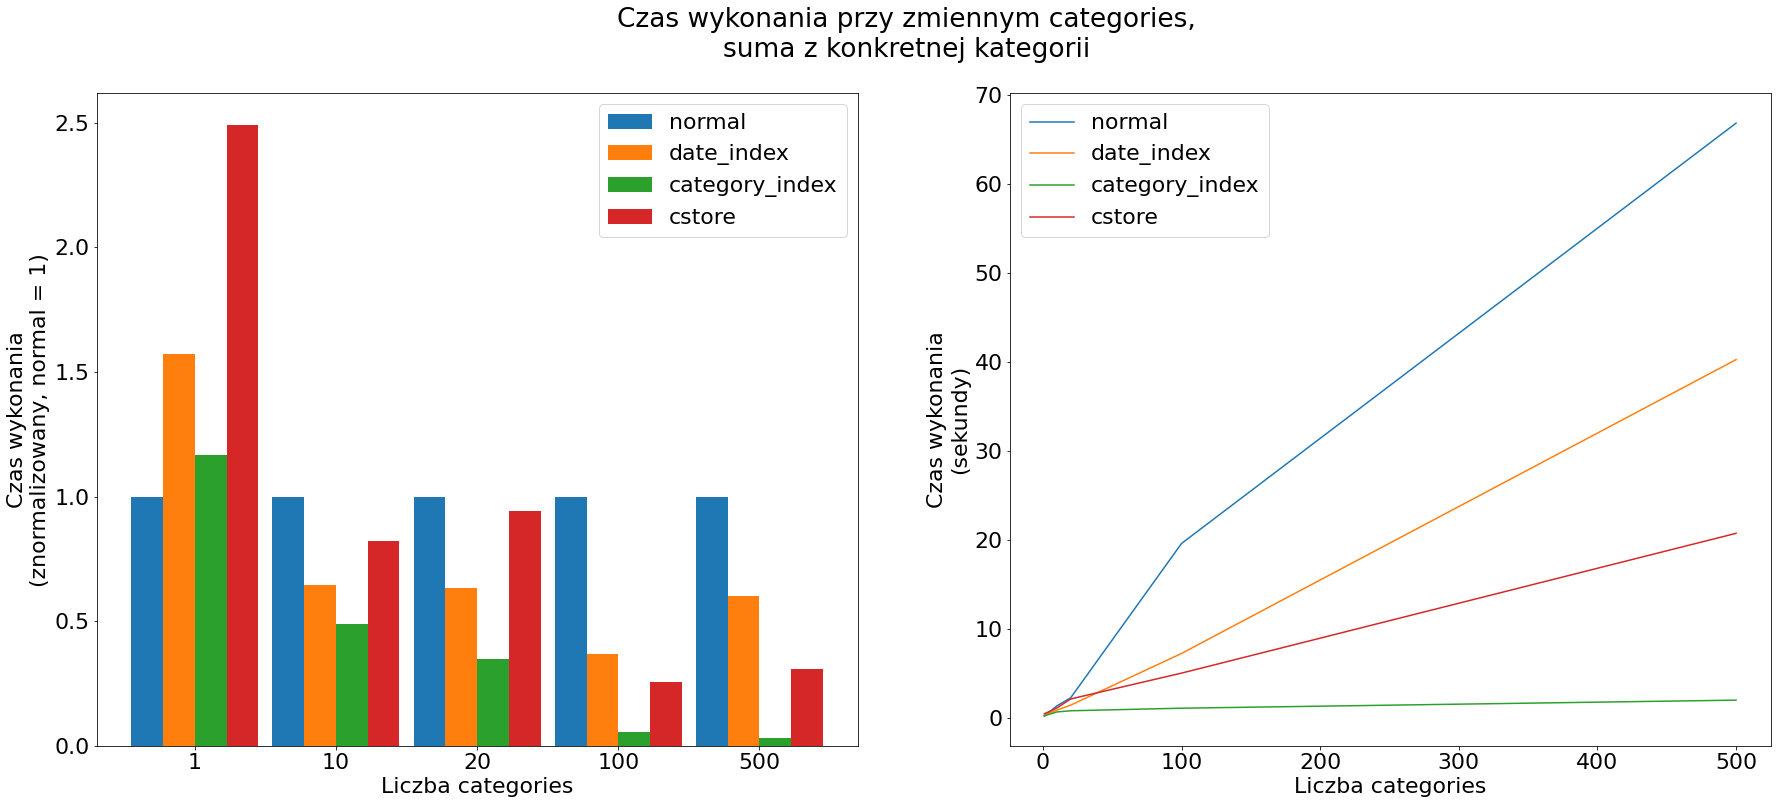

In [48]:
drawings.show_experiment(pg, plt, 'categories', True)

Tu widzimy, że jeśli nasze dane posiadają wiele kategorii, wybór najlepszej metody będzie uzależniony od tego jak często będziemy agregować po wszystkich kategoriach, a jak często z tylko jedną wybraną. Indeks na kategoriach zostawia pozostałe metody daleko w tyle przy drugim rodzaju zapytań, ale jest najgorszą metodą przy pierwszym, gdzie wygrywa `cstore`.

### Zmienna liczba kolumn

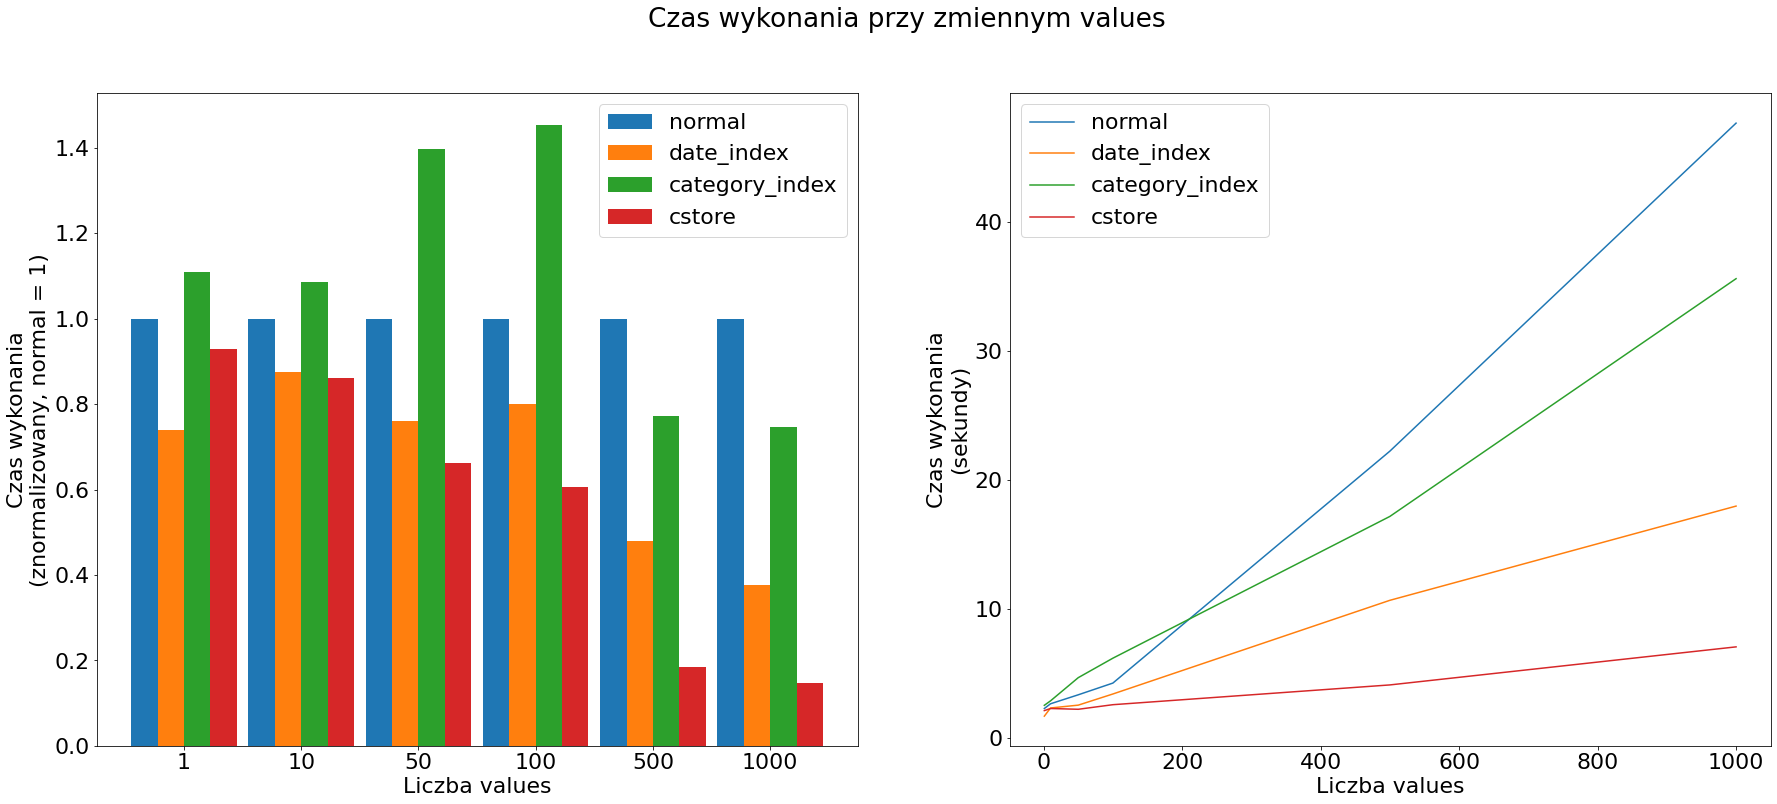

In [51]:
drawings.show_experiment(pg, plt, 'values', False)

Jak można się było spodziewać, `cstore` sprawia się świetnie kiedy interesuje nas prosta agregacja po pojedynczej kolumnie, a kolumn jest wiele. Indeks na datach sobie radzi, ale jednak zauważalnie zostaje w tyle.

Zaskakujące jest dla mnie zachowanie tabeli z indeksem na kategoriach (które są zupełnie nieistotne przy tych zapytaniach) &mdash; najpierw jest zauważalnie gorszy od zwykłej tabeli, ale od pewnej liczby kolumn, zauważalnie lepszy.

Sprawa jednak wygląda inaczej gdy agregujemy z danej kategorii:

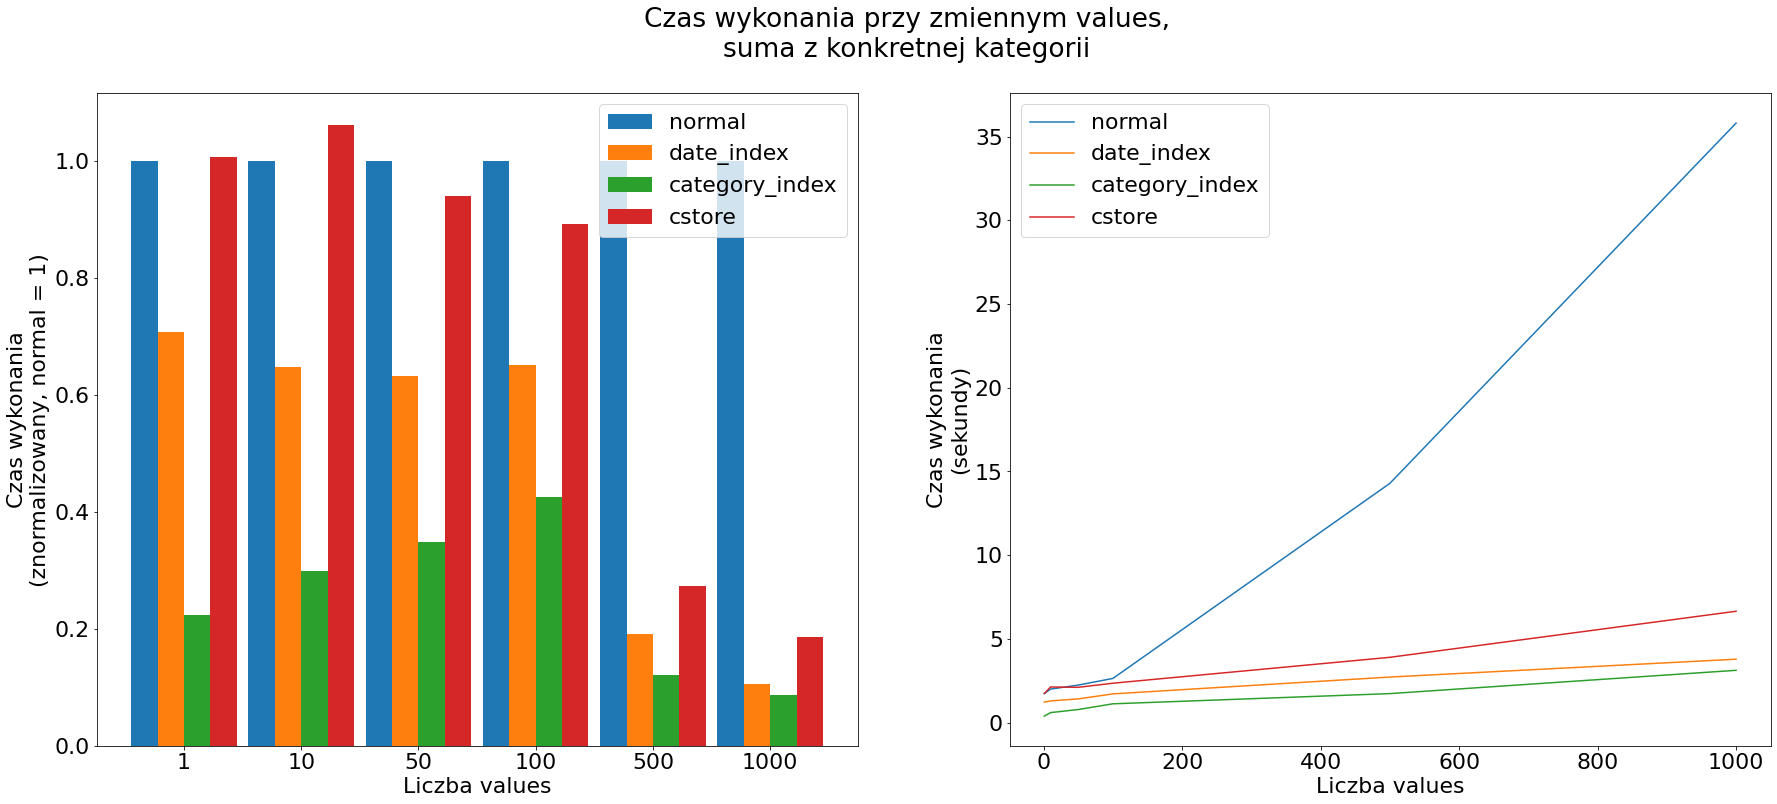

In [50]:
drawings.show_experiment(pg, plt, 'values', True)

Tu, przy dostatecznie wysokiej liczbie kolumn, `cstore` wciąż ma wyraźny zysk nad zwykłą tablą. Jednak oba rodzaje indeksu potrafią prześcignąć zapis kolumnowy, przy czym indeks na kategoriach radzi sobie lepiej.

### Zmienna długość przedziału czasowego

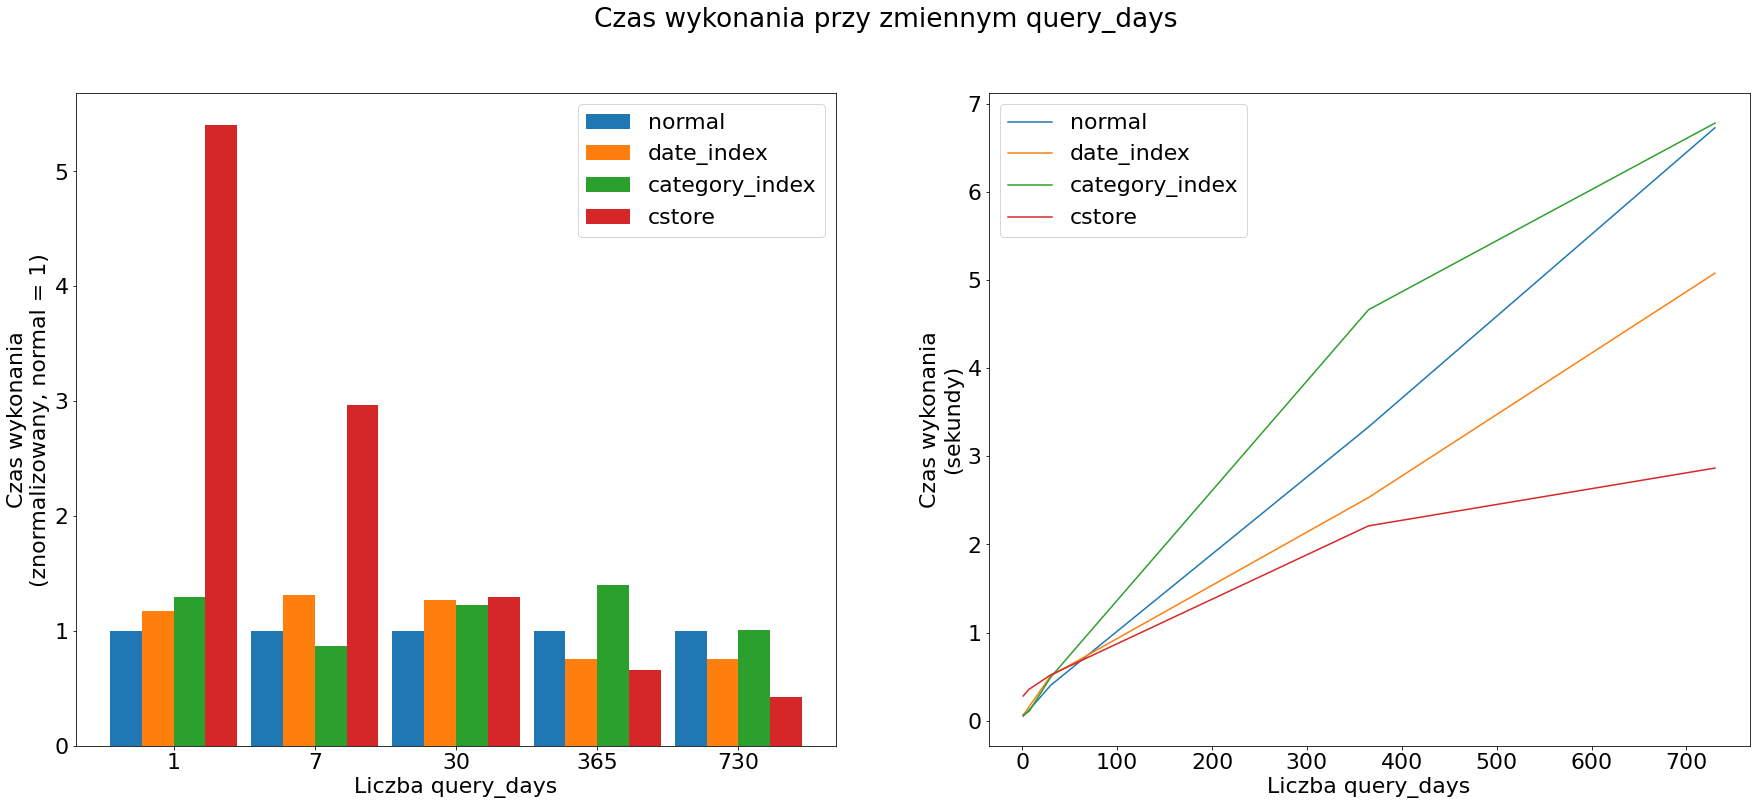

In [52]:
drawings.show_experiment(pg, plt, 'query_days', False)

To jest bardzo ciekawy przypadek. `cstore` jest *znacznie* gorszy przy któtkich przedziałach dat. Dopiero przy przedziałach długości jednego miesiąca staje się prównywalny z normalną tabelą, chociaż w tym momencie wciąż trochę gorszy. Zauważalny zysk widzimy dopiero w eksperymencie z przedziałami rocznymi, w którym `cstore` w ogóle wychodzi na prowadzenie.

Także wydajność czasowa zapisu kolumnowego jest bardzo uzależniona od tego, czy bardziej nas interesuje długofalowa analiza danych z przedziałów rzędu lat, czy aktualne trendy z, na przykład, ostatniego tygodnia/miesiąca.

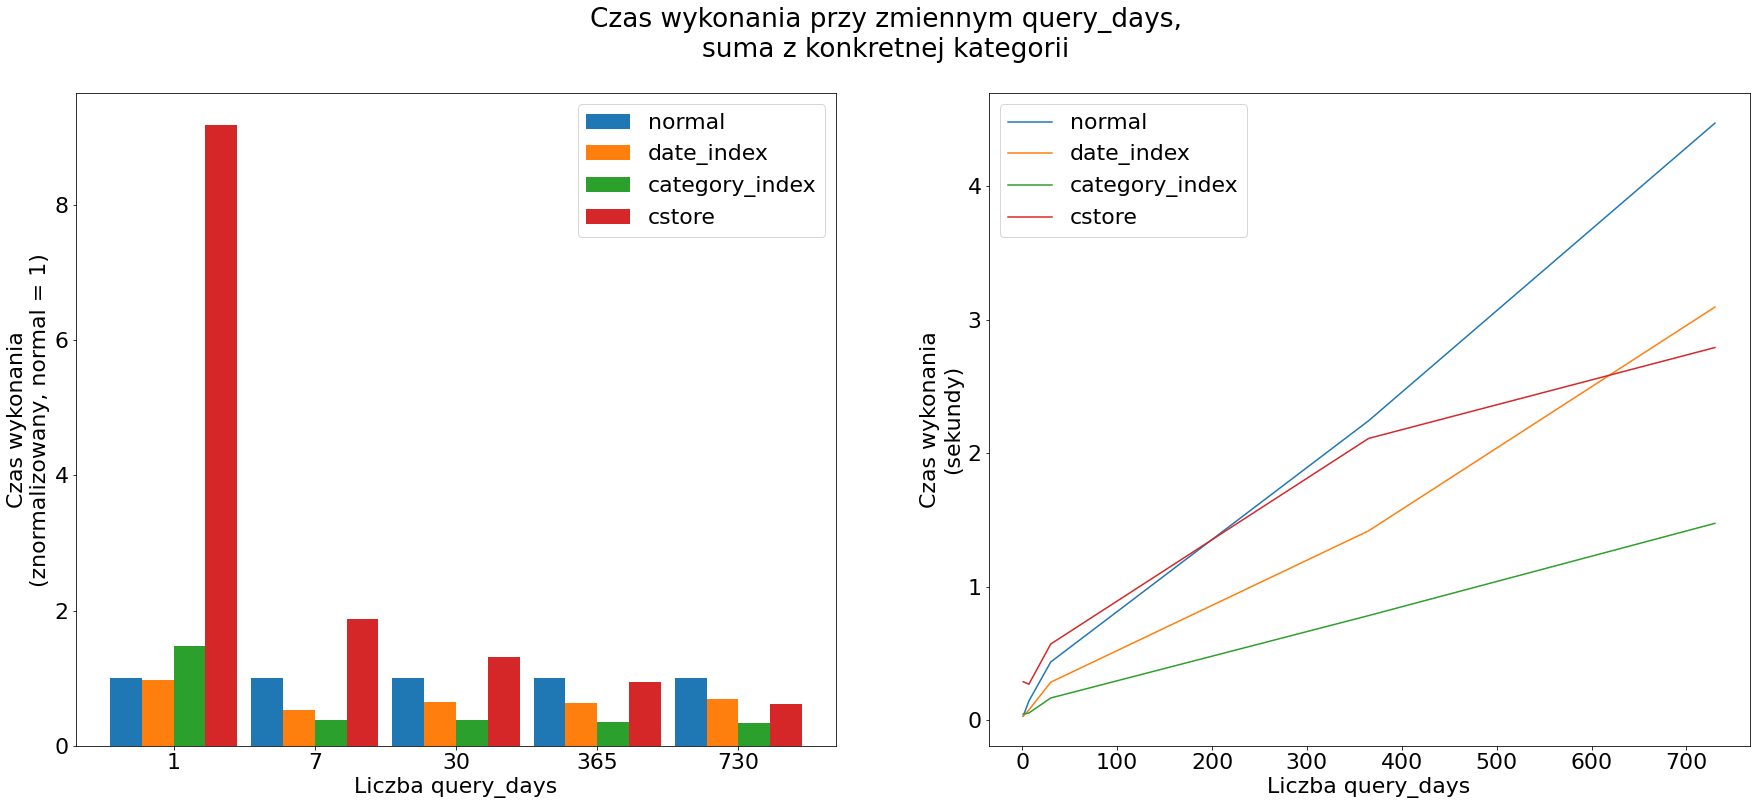

In [53]:
drawings.show_experiment(pg, plt, 'query_days', True)

Jak dodamy do analizy zapytania o konkretną kategorię, sytuacja staje się podobna do przypadku zmiennej liczby kategorii: indeks na kategoriach daje nam duże zyski na zapytaniach drugiego rodzaju, ale nie wypada najlepiej na tych pierwszego.

## Miejsce na dysku

Rozmiar pliku CSV można przyjąć za swego rodzaju "kanoniczny" rozmiar danych, więc na poniższym wykresie znormalizowaliśmy zajęcie dysku właśnie do romiaru pliku CSV. Możemy zobaczyć względnie jak porównują się ze sobą różne metody.

W przypadku efektywności wykorzystania miejsca na dysku, nie ma już tak ciekawych zależności jak w przypdaku czasów wykonania. Żeby nie robić za dużo bałaganu, pokazujemy tylko jeden wykres z podzbiorem danych, pozostałe wyglądają bardzo podobnie.

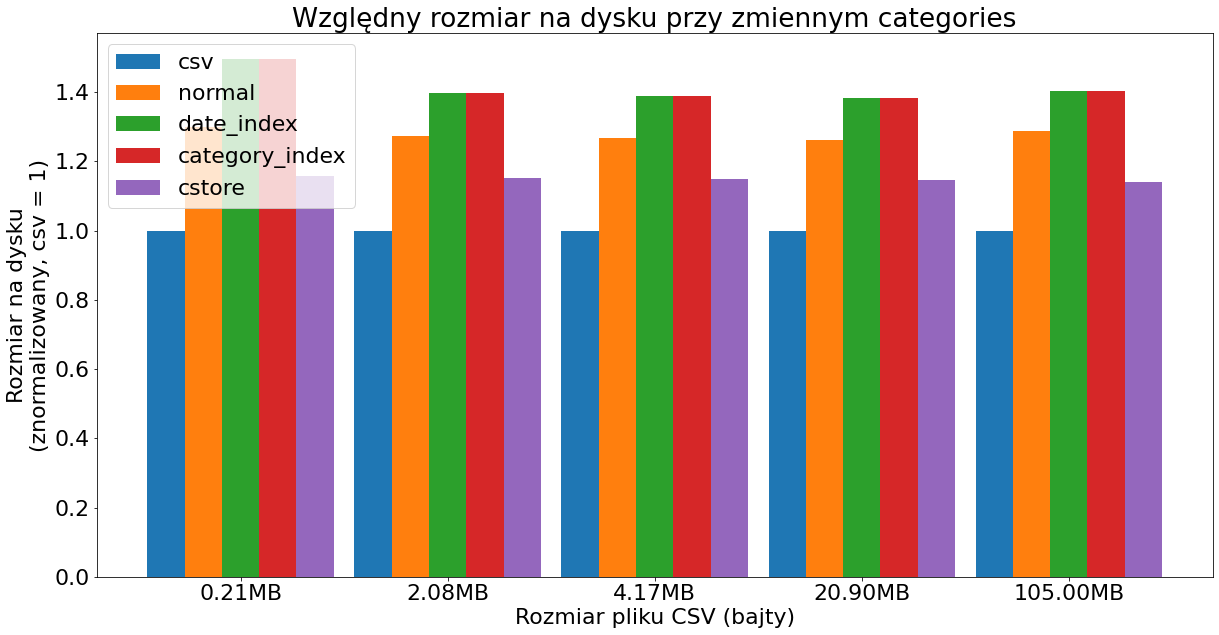

In [52]:
drawings.show_sizes(pg, plt, 'categories')

Z tego przykładu, widzimy skoki o mniej więcej dziesięć-kilkanaście procent &mdash; `cstore` jest 10-20% większy niż nasze oryginalne dane w CSV, zwykła tabela około 20-30% większa, a dodanie indeksu narzuca kolejne ~10%. 